In [1]:
source("~/software/notebook_assist/functions.R")
source("~/software/notebook_assist/packages.R")

setwd("../")
list.files()

[1] "figures"             "input"               "notebooks"          
[4] "source_data"         "supplemental_tables"

In [2]:
eqtl_path = "supplemental_tables/Table_SX_eQTLs.For_Print.txt"
caqtl_path = "supplemental_tables/Table_SX_caQTLs.For_Print.txt"
haqtl_path = "supplemental_tables/Table_SX_haQTLs.For_Print.txt"

### Fraction Early Developmental (EDev) QTLs - Figure 3a

In [112]:
summarize_edev = function(qtl_path, datatype) {
    qtl_df = fread(qtl_path, sep="\t",data.table=F) %>% filter(Significant == "TRUE") %>% mutate(n_edev = count(`Fetal-Unique`))
    out    = data.frame(Datatype = datatype, 
                        EDevUnique = unique(qtl_df$n_edev), 
                        nQTLs = nrow(qtl_df))
    out$Percent = (out$EDevUnique/out$nQTLs)*100
    return(out)
}

edev_summary = as.data.frame(rbindlist(list(summarize_edev(eqtl_path, "eQTL"),
                                             summarize_edev(caqtl_path, "caQTL"),
                                             summarize_edev(haqtl_path, "haQTL"))))

edev_summary$Datatype = factor(edev_summary$Datatype, levels = c("eQTL","caQTL","haQTL"))

In [173]:
edev_summary

Datatype,EDevUnique,nQTLs,Percent
<fct>,<int>,<int>,<dbl>
eQTL,2547,30265,8.415662
caQTL,6098,36559,16.679887
haQTL,1736,12257,14.163335


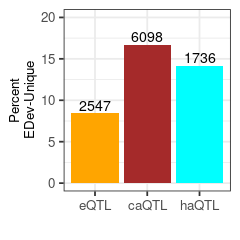

In [175]:
psize(2,2)
sum_plt = ggplot(edev_summary,aes(Datatype,Percent, fill=Datatype)) + geom_bar(stat="identity") + theme_bw() +
                ylim(c(0,20)) + ylab("Percent\nEDev-Unique") + xlab("") +
                theme(axis.text=element_text(size=8), axis.title = element_text(size=8),
                      legend.position = "none") +
                geom_text(aes(label=EDevUnique), position=position_dodge(width=0.9), vjust=-0.25, size=3) + 
                scale_fill_manual(values=c("orange","brown","cyan"))
    sum_plt

### EDev QTL distance - Figure 3b

In [115]:
snp_distances = fread("input/figure3/finemap_snp_distances.txt",sep="\t",data.table=F)
snp_distances$qtl_id = paste(snp_distances$Tissue, snp_distances$`Element ID`, snp_distances$Condition, sep="_")


In [138]:
edev_eqtl_df = fread(eqtl_path, sep="\t",data.table=F) %>% 
                    filter(Significant == "TRUE") %>% 
                    mutate(qtl_id = paste(Tissue,`Element ID`, Condition, sep="_")) %>%
                    select(qtl_id, `Fetal-Unique`, Beta)                    


In [155]:
edev_dist = merge(snp_distances, edev_eqtl_df)
edev_qtl_dist_test = wilcox.test(edev_dist$Closest[ edev_dist$`Fetal-Unique` == "TRUE"],
                                 edev_dist$Closest[ edev_dist$`Fetal-Unique` == "FALSE"],
                                 alternative = "greater")$p.value

message("Wilcox test for EDev QTL distance p-value = ",edev_qtl_dist_test)

edev_qtl_effect_test = wilcox.test(abs(edev_dist$Beta[ edev_dist$`Fetal-Unique` == "TRUE"]),
                                 abs(edev_dist$Beta[ edev_dist$`Fetal-Unique` == "FALSE"]),
                                   alternative = "less")$p.value

message("Wilcox test for EDev QTL effect size p-value = ",edev_qtl_effect_test)

edev_dist$Annotation = ifelse(edev_dist$`Fetal-Unique` == "TRUE", "EDev-unique","Shared")
dist_plt = ggplot(edev_dist, aes(Annotation, Closest/1000)) + theme_bw() +
                ylim(c(0,1250)) + ylab("Distance from\neGene TSS (kb)") +
                xlab("") +
                geom_boxplot(outlier.shape = NA) 

Wilcox test for EDev QTL distance p-value = 6.88109393982867e-222

Wilcox test for EDev QTL effect size p-value = 5.50584142962086e-12



### Fetal eQTL Constraint - Figure 3c
#### get constraint table `wget https://storage.googleapis.com/gcp-public-data--gnomad/release/4.0/constraint/gnomad.v4.0.constraint_metrics.tsv`

In [197]:
constraint = fread("input/figure3/gnomad.v4.0.constraint_metrics.tsv",sep="\t",data.table=F)


In [208]:
eqtl_constraint = unique(merge(unique(fread(eqtl_path, sep="\t",data.table=F) %>% filter(Significant == "TRUE")
                                %>% select(`Element Name`, `Fetal-Unique`) %>%
                                rename(gene = `Element Name`)), 
                        constraint[ constraint$mane_select == "TRUE", c("gene","lof_hc_lc.pLI")]))
length(unique(eqtl_constraint$gene))
eqtl_constraint$tissue_fetal = ifelse(eqtl_constraint$gene %in% 
                                      names(table(eqtl_constraint$gene)[ table(eqtl_constraint$gene) > 1]),"BOTH",
                                     ifelse(eqtl_constraint$`Fetal-Unique` == "TRUE","EDev-Unique","Shared"))
eqtl_constraint = eqtl_constraint[ eqtl_constraint$tissue_fetal != "BOTH",]
9132-nrow(eqtl_constraint)
head(rev(sort(table(eqtl_constraint$gene))))
eqtl_constraint$constrained = ifelse(eqtl_constraint$lof_hc_lc.pLI > 0.75 , "TRUE","FALSE")
fisher.test(matrix(c(133,310,1555,6177),nrow=2))
table(eqtl_constraint$constrained,eqtl_constraint$`Fetal-Unique`)

[1] 9132

[1] 957


  ZZZ3    ZYX ZYG11B   ZXDC ZWILCH   ZW10 
     1      1      1      1      1      1 


	Fisher's Exact Test for Count Data

data:  matrix(c(133, 310, 1555, 6177), nrow = 2)
p-value = 1.638e-06
alternative hypothesis: true odds ratio is not equal to 1
95 percent confidence interval:
 1.369647 2.111512
sample estimates:
odds ratio 
  1.704137 


       
        FALSE TRUE
  FALSE  6177  310
  TRUE   1555  133

In [191]:
breaks = seq(0,1,0.05)
eqtl_constraint$bin_annotation = cut(eqtl_constraint$lof_hc_lc.pLI, breaks, include.lowest = TRUE, labels = FALSE)
bin_labels = sprintf("(%0.2f, %0.2f]", head(breaks, -1), tail(breaks, -1))
eqtl_constraint$bin_annotation_label <- cut(eqtl_constraint$lof_hc_lc.pLI, breaks, include.lowest = TRUE, labels = bin_labels)
eqtl_constraint_tab = as.data.frame(table(eqtl_constraint$tissue_fetal,eqtl_constraint$bin_annotation_label))%>% 
                                        group_by(Var1) %>% mutate(Fraction = (Freq/sum(Freq)*100)) %>%
                                        rename(Stage = Var1, pLI = Var2)
psize(3,4.5)

constraint_pval = wilcox.test(eqtl_constraint$lof_hc_lc.pLI[ eqtl_constraint$tissue_fetal == "EDev-Unique"],
           eqtl_constraint$lof_hc_lc.pLI[ eqtl_constraint$tissue_fetal == "Shared"])$p.value
constraint_pval
cons_plt =ggplot(eqtl_constraint_tab, aes(pLI,Fraction, fill=Stage )) + theme_bw() +
                theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1)) +
                ylab("Percent\neGenes") + xlab("Constraint (pLI)") +
                geom_bar(stat="identity", position="dodge") +
                scale_fill_manual(values=c("#386CB0","#A65628"))

[1] 9.664909e-07

In [196]:
psize(4,4.5)
png("figures/Figure3.png",res=300,units="in",height = 4,width = 4.5)
plot_grid(plot_grid(sum_plt, dist_plt, nrow=1, rel_widths = c(0.7,1), labels=c("a","c")),
          plot_grid(cons_plt, labels=c("b")), nrow=2)
dev.off()

Warning message:
“Removed 9 rows containing non-finite values (`stat_boxplot()`).”


png 
  2